In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from pycaret.classification import *

In [16]:
hydrothermal_deposits_df = pd.read_csv("Hydrothermal_deposits.csv")
porphyry_deposits_df = pd.read_csv("Phorphy_deposits.csv")
sedex_deposits_df = pd.read_csv("Sedex _Deposits.csv")
vms_deposits_df = pd.read_csv("VMS_Dataset.csv")
epithermal_deposits_df = pd.read_csv("epithermal_Deposists.csv")

In [17]:
hydrothermal_deposits_df['Deposit_Type'] = 'Hydrothermal'
porphyry_deposits_df['Deposit_Type'] = 'Porphyry'
sedex_deposits_df['Deposit_Type'] = 'Sedex'
vms_deposits_df['Deposit_Type'] = 'VMS'
epithermal_deposits_df['Deposit_Type'] = 'Epithermal'

In [18]:
# --- 1. Load and Clean Porphyry Data ---
# This file is mostly clean but has many empty cells and blank rows at the end.
porphyry_df = pd.read_csv('Phorphy_deposits.csv')
porphyry_df.dropna(how='all', inplace=True) # Drop rows where all values are missing
porphyry_df['Deposit_Type'] = 'Porphyry'
print("Porphyry data loaded and cleaned.")


Porphyry data loaded and cleaned.


In [19]:
# --- 2. Load and Clean SEDEX Data ---
# The column names have extra spaces around them.
sedex_df = pd.read_csv('Sedex _Deposits.csv')
sedex_df.columns = sedex_df.columns.str.strip() # Remove leading/trailing spaces from headers
sedex_df['Deposit_Type'] = 'SEDEX'
print("SEDEX data loaded and cleaned.")


SEDEX data loaded and cleaned.


In [20]:
# --- 3. Load and Clean VMS Data ---
# This file has junk rows at the beginning and empty columns/rows at the end.
# We skip the first two rows which are not data.
vms_df = pd.read_csv('VMS_Dataset.csv', header=1)

# The junk row of numbers ('0.005', '0.010'...) is now the first data row (at index 0).
# We must drop it by its index.
vms_df.drop(vms_df.index[0], inplace=True)

# Now, we proceed with the other cleaning steps for this file.
vms_df = vms_df.iloc[:, :-2] # Drop the last two completely empty columns
vms_df.dropna(how='all', inplace=True) # Drop empty rows from the end
vms_df['Deposit_Type'] = 'VMS'
print("VMS data loaded and cleaned.")



VMS data loaded and cleaned.


In [21]:
# --- 4. Load and Clean Epithermal Data ---
# The first column has a very messy name. We will rename it to 'Fe'.
epithermal_df = pd.read_csv('epithermal_Deposists.csv')
# Rename the first column to 'Fe' for consistency.
epithermal_df.rename(columns={epithermal_df.columns[0]: 'Fe'}, inplace=True)
epithermal_df['Deposit_Type'] = 'Epithermal'
print("Epithermal data loaded and cleaned.")


Epithermal data loaded and cleaned.


In [22]:
hydrothermal_df = pd.read_csv('Hydrothermal_deposits.csv', header=0)
hydrothermal_df = hydrothermal_df.iloc[2:].reset_index(drop=True)
hydrothermal_df.columns = hydrothermal_df.columns.str.strip()
hydrothermal_df.replace('b.d', np.nan, inplace=True)
hydrothermal_df.drop(columns=['Analysis spots'], inplace=True)
hydrothermal_df.dropna(thresh=5, inplace=True)
hydrothermal_df['Deposit_Type'] = 'Hydrothermal'
print("Hydrothermal data loaded and cleaned.")

Hydrothermal data loaded and cleaned.


In [23]:
# --- 6. Combine all DataFrames ---
# Now, we combine them. Because they don't share all the same columns,
# pandas will create NaN values where a column from one file doesn't exist in another.
# This is expected and we will handle it in the next phase.
master_df = pd.concat([
    porphyry_df,
    sedex_df,
    vms_df,
    epithermal_df,
    hydrothermal_df
], ignore_index=True)

master_df.drop(columns=['Total'], inplace=True, errors='ignore')


In [24]:
# Convert all possible columns to numeric types. Errors will become NaN.
for col in master_df.columns:
    if col != 'Deposit_Type':
        master_df[col] = pd.to_numeric(master_df[col], errors='coerce')

print("\nAll data combined into 'master_df'.")

# --- 7. Final Inspection ---
print("\nMaster DataFrame Info (shows data types and non-null counts):")
master_df.info()

print("\nShape of the final combined DataFrame:", master_df.shape)

print("\nNumber of samples per deposit type:")
print(master_df['Deposit_Type'].value_counts())

# Save the cleaned master DataFrame to a new CSV to use in the next phases.
master_df.to_csv('master_mineral_data.csv', index=False)
print("\nCleaned master DataFrame saved to 'master_mineral_data.csv'")


All data combined into 'master_df'.

Master DataFrame Info (shows data types and non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 51 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   P             130 non-null    float64
 1   Ti            375 non-null    float64
 2   Cr            459 non-null    float64
 3   Co            614 non-null    float64
 4   Ni            615 non-null    float64
 5   Cu            613 non-null    float64
 6   Zn            615 non-null    float64
 7   As            610 non-null    float64
 8   Se            594 non-null    float64
 9   Rb            202 non-null    float64
 10  Sr            221 non-null    float64
 11  Mo            356 non-null    float64
 12  Ag            605 non-null    float64
 13  Sb            568 non-null    float64
 14  La            74 non-null     float64
 15  Ce            78 non-null     float64
 16  Pr            73

In [25]:
# Load the master dataset you created in Phase 1
master_df = pd.read_csv('master_mineral_data.csv')

print("Data loaded successfully.")
print("Shape of the dataset:", master_df.shape)
master_df.head()

Data loaded successfully.
Shape of the dataset: (615, 51)


,P,Ti,Cr,Co,Ni,Cu,Zn,As,Se,Rb,Sr,Mo,Ag,Sb,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,W,Bi,Pb,Deposit_Type,Fe,Ge,Te,Au,S,V,Mn,Cd,Sn,Ba,Tl,Na,Mg,Al,Si,K,Ca,Ga,In
0,90.5170,6.2105,1.1737,4116.7326,81.4529,0.2898,1.4136,257.9315,NaN,0.5063,0.1797,0.0081,0.0729,0.0579,0.0032,NaN,NaN,0.0573,0.1481,0.0046,NaN,NaN,NaN,NaN,0.0068,0.0022,0.0106,NaN,0.0109,0.9274,1.3202,Porphyry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109.9606,4.9979,0.8826,2384.6766,224.7375,3.0433,2.4632,15.0667,19.4082,3.4249,1.2470,0.0237,0.0928,NaN,0.0074,NaN,0.0046,NaN,0.1728,NaN,NaN,NaN,NaN,0.0019,NaN,NaN,0.0082,0.0024,NaN,26.4284,45.5069,Porphyry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,118.3088,6.5557,0.2061,1275.4860,52.7874,0.1746,1.6272,24.1259,25.6262,0.4048,0.2831,0.0755,NaN,0.0013,0.0026,NaN,0.0008,NaN,0.0779,NaN,0.0129,0.0017,0.0077,0.0020,0.0055,0.0036,0.0086,0.0019,NaN,1.0729,1.0671,Porphyry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,113.1241,5.1639,1.6516,1245.6729,194.2875,0.2385,1.4484,8.9044,28.5042,0.5627,0.2871,0.1188,0.0244,0.0387,NaN,0.0078,0.0094,0.0672,NaN,0.0058,0.0102,NaN,0.0181,0.0016,NaN,NaN,0.0067,0.0015,0.0069,2.3785,1.9120,Porphyry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,77.8263,5.1099,4.4611,1814.9775,175.4654,0.8483,2.0768,3.9935,11.5739,0.0165,0.0574,0.1901,NaN,0.0469,NaN,0.0140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0173,NaN,NaN,0.5252,0.3931,Porphyry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Separate 85% for training/validation and 15% for the final hold-out test set
# We use 'stratify' to ensure the proportion of each deposit type is the same in both sets
data_for_pycaret, holdout_test_set = train_test_split(
    master_df, 
    test_size=0.15, 
    random_state=42, 
    stratify=master_df['Deposit_Type']
)

print("Data for PyCaret (Training):", data_for_pycaret.shape)
print("Hold-out Test Set:", holdout_test_set.shape)

Data for PyCaret (Training): (522, 51)
Hold-out Test Set: (93, 51)


In [27]:
# Initialize the PyCaret classification environment
# session_id is a random seed for reproducibility
clf_setup = setup(
    data=data_for_pycaret, 
    target='Deposit_Type', 
    numeric_imputation='median',  # Use median to fill missing numbers
    session_id=123
)

,Description,Value
0,Session id,123
1,Target,Deposit_Type
2,Target type,Multiclass
3,Target mapping,"Epithermal: 0, Hydrothermal: 1, Porphyry: 2, SEDEX: 3, VMS: 4"
4,Original data shape,"(522, 51)"
5,Transformed data shape,"(522, 51)"
6,Transformed train set shape,"(365, 51)"
7,Transformed test set shape,"(157, 51)"
8,Numeric features,50
9,Rows with missing values,100.0%


In [28]:
# This command trains and evaluates multiple models, then returns the best one.
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1520
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1250
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,211.5280
catboost,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.8820
dt,Decision Tree Classifier,0.9944,0.9966,0.9944,0.9948,0.9945,0.9930,0.9931,0.0300
xgboost,Extreme Gradient Boosting,0.9917,0.9999,0.9917,0.9923,0.9916,0.9895,0.9897,0.1110
gbc,Gradient Boosting Classifier,0.9892,0.0000,0.9892,0.9915,0.9884,0.9863,0.9872,0.7520
lr,Logistic Regression,0.9864,0.0000,0.9864,0.9884,0.9863,0.9829,0.9835,1.2910
nb,Naive Bayes,0.9781,0.9971,0.9781,0.9810,0.9779,0.9725,0.9733,0.0410
knn,K Neighbors Classifier,0.9586,0.9927,0.9586,0.9654,0.9585,0.9482,0.9502,0.0320


In [29]:
# Create a Random Forest model instance
rf_model = create_model('rf')

# Automatically tune the hyperparameters of the Random Forest model
tuned_rf_model = tune_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
# Finalize the model (retrains it on the full training dataset)
final_model = finalize_model(tuned_rf_model)

# Use the final model to make predictions on the hold-out test data
predictions = predict_model(final_model, data=holdout_test_set)

# The 'predictions' DataFrame will show the original test data with new columns
# for the predicted label and confidence score. The accuracy score printed here
# is the most important one.
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,P,Ti,Cr,Co,Ni,Cu,Zn,As,Se,Rb,...,Mg,Al,Si,K,Ca,Ga,In,Deposit_Type,prediction_label,prediction_score
119,61.3186,5.4394,0.8626,1821.818604,89.3479,41.268799,63.079899,1.1782,18.194901,0.0641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Porphyry,Porphyry,0.97
261,NaN,7.1100,3.1800,19.610001,2.8700,51.360001,8.020000,8.0300,222.910004,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VMS,VMS,1.00
489,NaN,NaN,NaN,0.010000,0.1800,0.100000,0.160000,0.2600,0.470000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Epithermal,Epithermal,1.00
266,NaN,6.4100,5.4200,1.540000,0.8300,227.899994,2.820000,14.4400,310.119995,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VMS,VMS,0.99
400,NaN,NaN,NaN,0.010000,0.2100,0.110000,0.180000,0.2800,0.330000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Epithermal,Epithermal,1.00


In [31]:
# Save the final model pipeline to a file
save_model(final_model, 'mineral_deposit_classifier')

print("Model saved as 'mineral_deposit_classifier.pkl'")

Transformation Pipeline and Model Successfully Saved
Model saved as 'mineral_deposit_classifier.pkl'


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib 

master_df = pd.read_csv('master_mineral_data.csv')

if 'Total' in master_df.columns:
    master_df.drop(columns=['Total'], inplace=True, errors='ignore')

print("Data loaded successfully.")
master_df.head()

Data loaded successfully.


,P,Ti,Cr,Co,Ni,Cu,Zn,As,Se,Rb,...,Ba,Tl,Na,Mg,Al,Si,K,Ca,Ga,In
0,90.5170,6.2105,1.1737,4116.7326,81.4529,0.2898,1.4136,257.9315,NaN,0.5063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109.9606,4.9979,0.8826,2384.6766,224.7375,3.0433,2.4632,15.0667,19.4082,3.4249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,118.3088,6.5557,0.2061,1275.4860,52.7874,0.1746,1.6272,24.1259,25.6262,0.4048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,113.1241,5.1639,1.6516,1245.6729,194.2875,0.2385,1.4484,8.9044,28.5042,0.5627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,77.8263,5.1099,4.4611,1814.9775,175.4654,0.8483,2.0768,3.9935,11.5739,0.0165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
X = master_df.drop('Deposit_Type', axis=1)

y_text = master_df['Deposit_Type']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y_text.shape)

Features (X) shape: (615, 50)
Target (y) shape: (615,)


In [34]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y_text)

print("Text labels:", label_encoder.classes_)
print("Encoded labels:", np.unique(y))

Text labels: ['Epithermal' 'Hydrothermal' 'Porphyry' 'SEDEX' 'VMS']
Encoded labels: [0 1 2 3 4]


In [35]:
imputer = SimpleImputer(strategy='constant', fill_value=0)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model_pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('classifier', rf_classifier)
])

print("Pipeline created successfully.")

Pipeline created successfully.


In [36]:
scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')

print("--- Cross-Validation Scores ---")
print("Scores for each fold:", scores)
print("\nMean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

--- Cross-Validation Scores ---
Scores for each fold: [1. 1. 1. 1. 1.]

Mean Accuracy: 1.0
Standard Deviation: 0.0


In [37]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X, y)

print("\n--- Grid Search Results ---")
print("Best Parameters Found:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

--- Grid Search Results ---
Best Parameters Found: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
Best Cross-Validated Accuracy: 1.0


In [ ]:
model_features = X.columns.tolist()

joblib.dump(final_model, 'mineral_deposit_classifier_sklearn.pkl')
print("Final model saved as 'mineral_deposit_classifier_sklearn.pkl'")

joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label encoder saved as 'label_encoder.pkl'")

joblib.dump(model_features, 'model_features.pkl')
print("Model features saved as 'model_features.pkl'")

Final model saved as 'mineral_deposit_classifier_sklearn.pkl'
Label encoder saved as 'label_encoder.pkl'
Model features saved as 'model_features.pkl'


In [ ]:
validation_score = grid_search.best_score_

training_score = grid_search.best_estimator_.score(X, y)

print(f"Cross-Validation Accuracy (on unseen folds): {validation_score:.4f}")
print(f"Full Training Set Accuracy (on seen data):   {training_score:.4f}")
print(f"Overfitting Gap:                              {training_score - validation_score:.4f}")

Cross-Validation Accuracy (on unseen folds): 1.0000
Full Training Set Accuracy (on seen data):   1.0000
Overfitting Gap:                              0.0000


--- Correlation Matrix for Porphyry Deposits ---


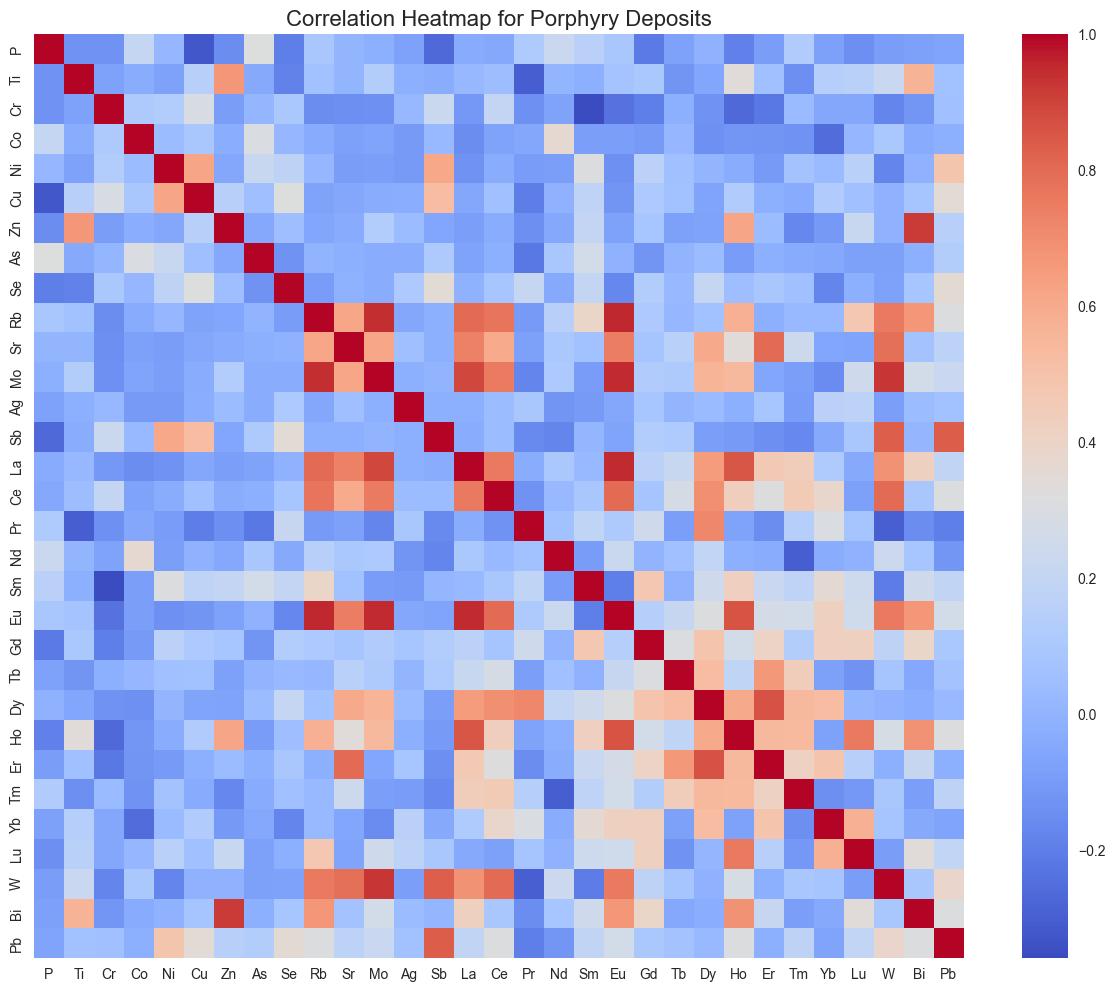




--- Correlation Matrix for SEDEX Deposits ---


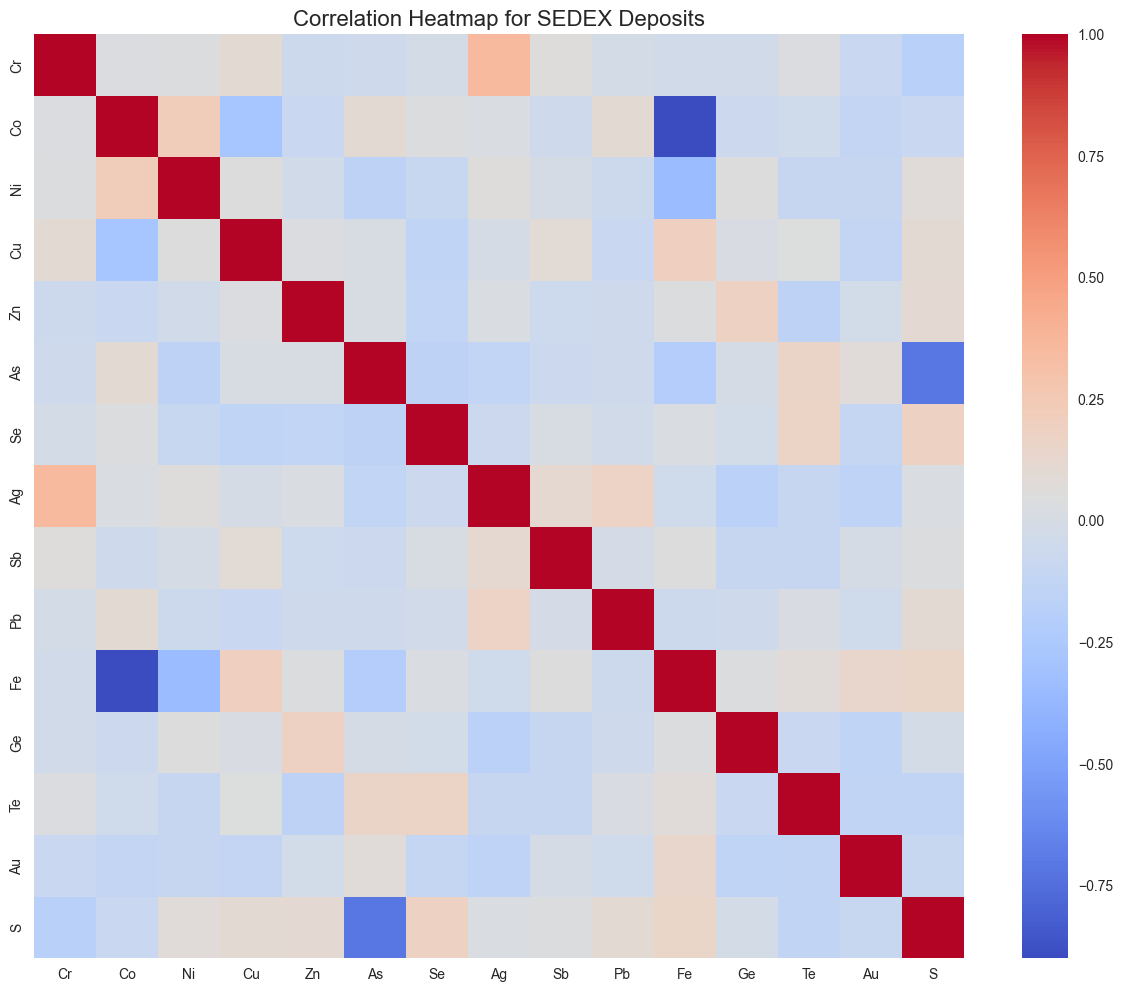




--- Correlation Matrix for VMS Deposits ---


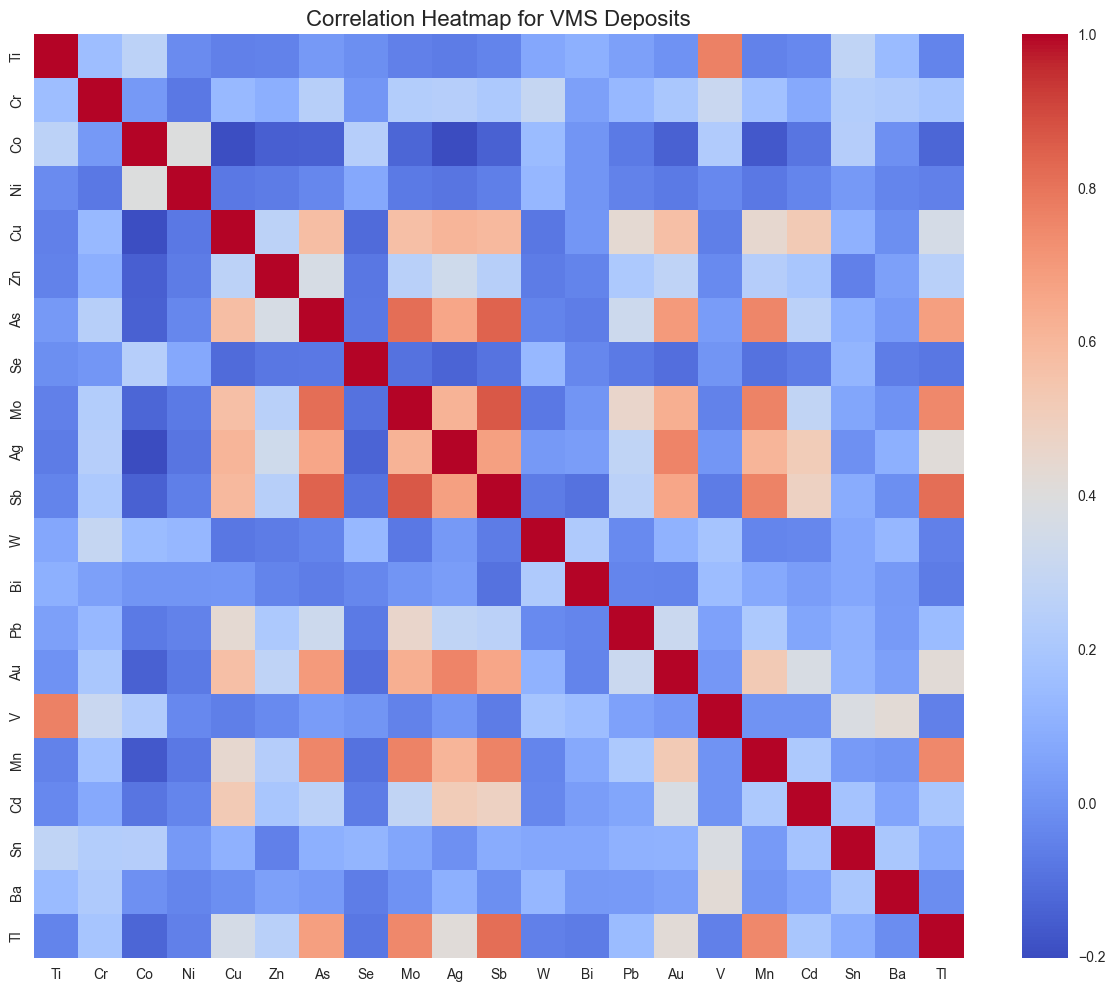




--- Correlation Matrix for Epithermal Deposits ---


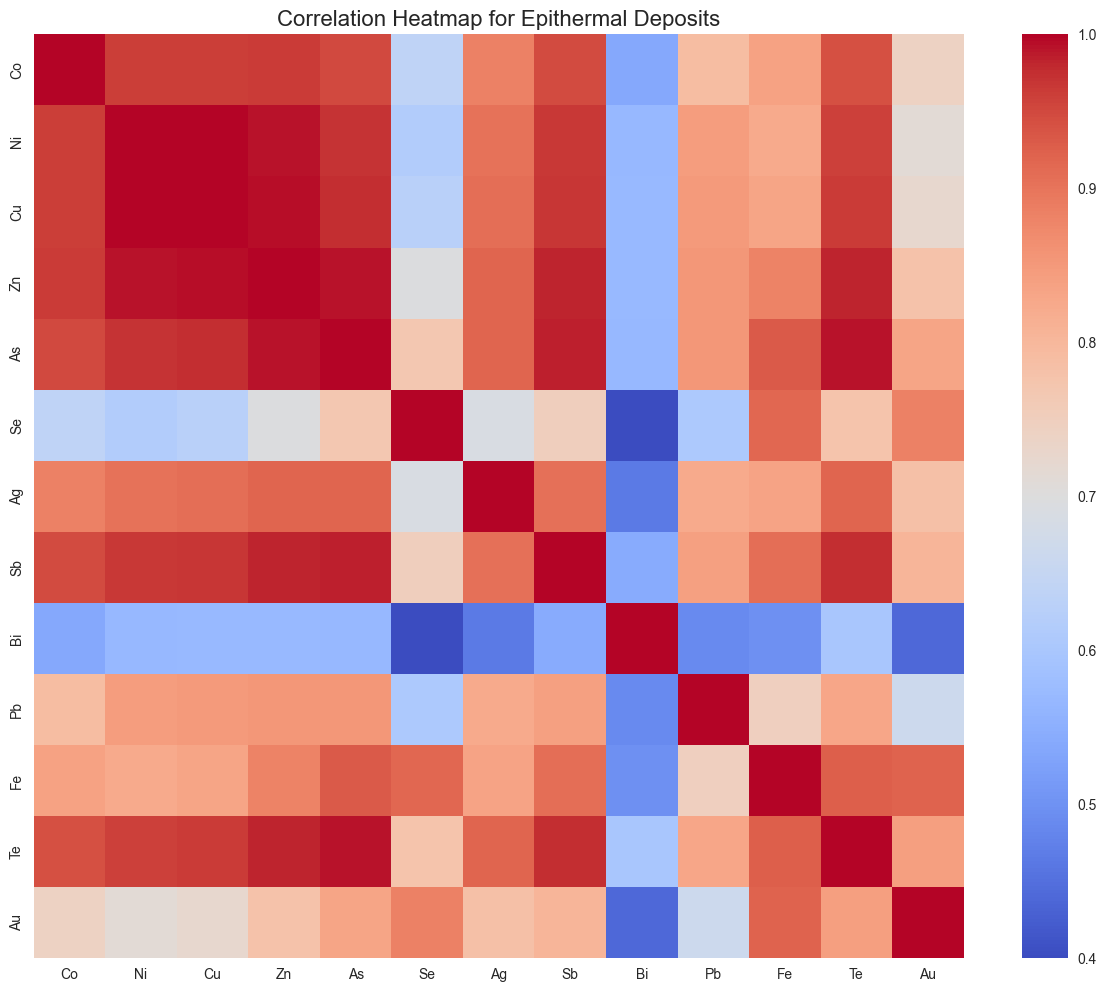




--- Correlation Matrix for Hydrothermal Deposits ---


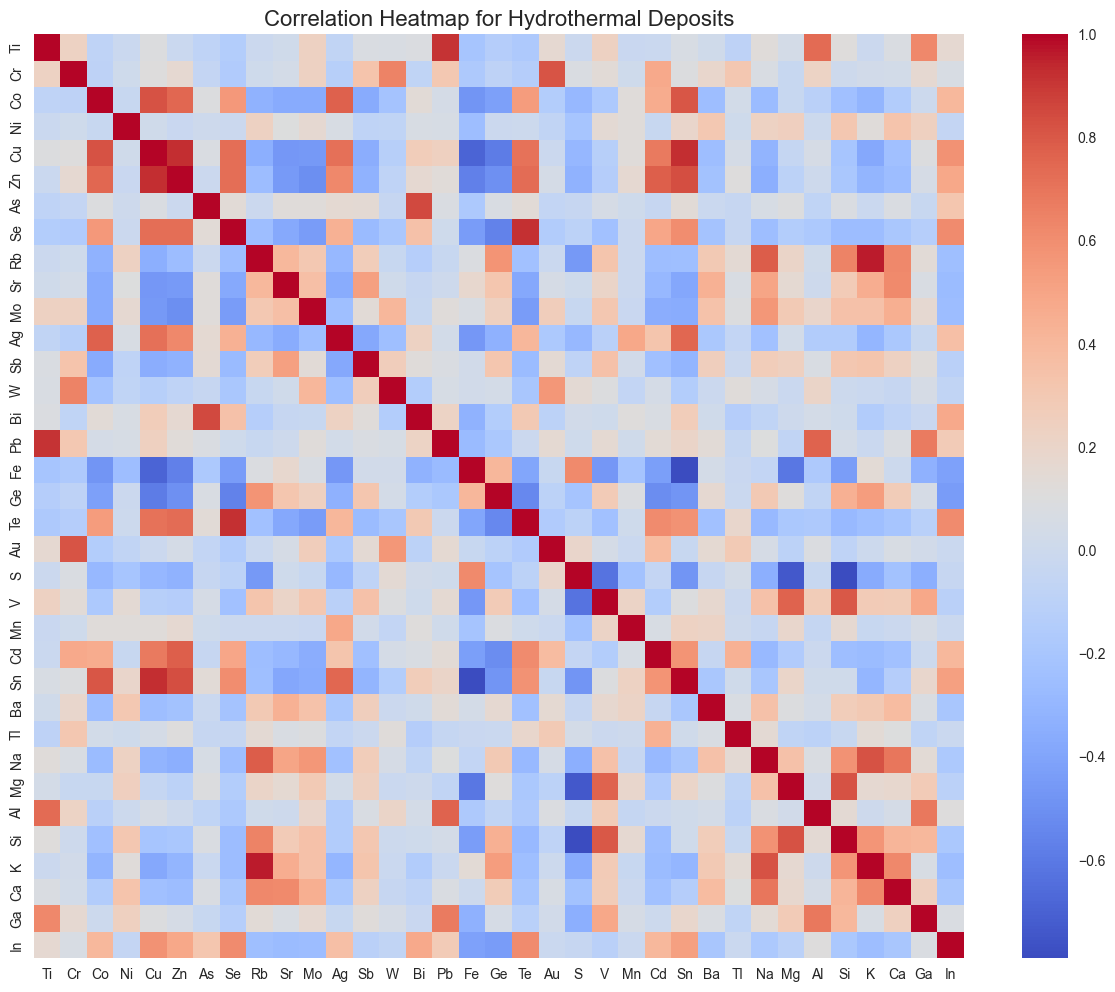

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

deposit_types = master_df['Deposit_Type'].unique()

plt.rcParams['figure.figsize'] = [15, 12]

for deposit in deposit_types:
    print(f"--- Correlation Matrix for {deposit} Deposits ---")
    deposit_df = master_df[master_df['Deposit_Type'] == deposit]
    deposit_df_numeric = deposit_df.select_dtypes(include=np.number)
    deposit_df_present = deposit_df_numeric.dropna(axis='columns', how='all')
    corr_matrix = deposit_df_present.corr()
    if corr_matrix.empty:
        print(f"No sufficient data to generate a correlation matrix for {deposit}.")
    else:
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
        plt.title(f'Correlation Heatmap for {deposit} Deposits', fontsize=16)
        plt.show()
    print("\n" * 2)